<a href="https://colab.research.google.com/github/tanvigunjal/Generating-Adversarial-Perturbations-using-Generative-Models/blob/main/chocoBelgium_GenerativeAdversarialPerturbations.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
import torch
torch.cuda.empty_cache()

In [ ]:
# Import libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torchvision
from datetime import datetime as dt

import torch
from torch import optim, nn
from torch.utils.data import DataLoader, TensorDataset, Dataset
from torchvision.utils import make_grid
from torchvision import transforms as T
from torchvision import models, datasets
#from generator.generator import ResnetGenerator, weights_init
import torch.backends.cudnn as cudnn


#import opendatasets as od
import os
from random import randint
import urllib
import zipfile

In [ ]:
# Define device to use (CPU or GPU). CUDA = GPU support for PyTorch
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")
print(device)

cuda


In [ ]:
# Retrieve data directly from Stanford data source
!wget http://cs231n.stanford.edu/tiny-imagenet-200.zip

--2022-02-04 19:55:05--  http://cs231n.stanford.edu/tiny-imagenet-200.zip
Resolving cs231n.stanford.edu (cs231n.stanford.edu)... 171.64.68.10
Connecting to cs231n.stanford.edu (cs231n.stanford.edu)|171.64.68.10|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 248100043 (237M) [application/zip]
Saving to: ‘tiny-imagenet-200.zip’

tiny-imagenet-200.z 100%[===================>] 236.61M  83.0MB/s    in 2.9s    

2022-02-04 19:55:08 (83.0 MB/s) - ‘tiny-imagenet-200.zip’ saved [248100043/248100043]



In [ ]:
# # Unzip raw zip file
# !unzip 'tiny-imagenet-200.zip'

Streaming output truncated to the last 5000 lines.
  inflating: tiny-imagenet-200/val/images/val_3979.JPEG  
  inflating: tiny-imagenet-200/val/images/val_3963.JPEG  
  inflating: tiny-imagenet-200/val/images/val_7199.JPEG  
  inflating: tiny-imagenet-200/val/images/val_2752.JPEG  
  inflating: tiny-imagenet-200/val/images/val_9687.JPEG  
  inflating: tiny-imagenet-200/val/images/val_9407.JPEG  
  inflating: tiny-imagenet-200/val/images/val_3603.JPEG  
  inflating: tiny-imagenet-200/val/images/val_3412.JPEG  
  inflating: tiny-imagenet-200/val/images/val_6982.JPEG  
  inflating: tiny-imagenet-200/val/images/val_8496.JPEG  
  inflating: tiny-imagenet-200/val/images/val_7332.JPEG  
  inflating: tiny-imagenet-200/val/images/val_9241.JPEG  
  inflating: tiny-imagenet-200/val/images/val_4196.JPEG  
  inflating: tiny-imagenet-200/val/images/val_5980.JPEG  
  inflating: tiny-imagenet-200/val/images/val_6697.JPEG  
  inflating: tiny-imagenet-200/val/images/val_9969.JPEG  
  inflating: tiny-ima

In [ ]:
# # Refactor val directory

# import io
# import pandas as pd
# import glob
# import os
# from shutil import move
# from os.path import join
# from os import listdir, rmdir

# target_folder = '/content/tiny-imagenet-200/val/'

# val_dict = {}
# with open(target_folder + 'val_annotations.txt', 'r') as f:
#     for line in f.readlines():
#         split_line = line.split('\t')
#         val_dict[split_line[0]] = split_line[1]
        
# paths = glob.glob(target_folder + 'images/*')
# paths[0].split('/')[-1]
# for path in paths:
#     file = path.split('/')[-1]
#     folder = val_dict[file]
#     if not os.path.exists(target_folder + str(folder)):
#         os.mkdir(target_folder + str(folder))
        
# for path in paths:
#     file = path.split('/')[-1]
#     folder = val_dict[file]
#     dest = target_folder + str(folder) + '/' + str(file)
#     move(path, dest)
    
# os.remove('/content/tiny-imagenet-200/val/val_annotations.txt')
# rmdir('/content/tiny-imagenet-200/val/images')

In [ ]:
# Define main data directory
DATA_DIR = '/content/tiny-imagenet-200' # Original images come in shapes of [3,64,64]

# Define training and validation data paths
TRAIN_DIR = os.path.join(DATA_DIR, 'train') 
VALID_DIR = os.path.join(DATA_DIR, 'val')

In [ ]:
# Helper functions
# Functions to display single or a batch of sample images
def imshow(img):
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()
    
def show_batch(dataloader):
    dataiter = iter(dataloader)
    images, labels = dataiter.next()    
    imshow(make_grid(images)) # Using Torchvision.utils make_grid function
    
def show_image(dataloader):
    dataiter = iter(dataloader)
    images, labels = dataiter.next()
    random_num = randint(0, len(images)-1)
    imshow(images[random_num])
    label = labels[random_num]
    print(f'Label: {label}, Shape: {images[random_num].shape}')


In [ ]:

# ! ------------------------- TRAIN SETTINGS --------------------------- ! 
# magnitude of perturbation
mag_in = 20.0
batch_size = 4
testBatchSize = 4
lr = 0.0002
beta1 = 0.5


nEpochs = 10
threads = 4
seed = 123
MaxIter = 50
MaxIterTest = 1700 # During Test keep it 1700, 160 train
# experiment name, output folder
expname = '/content/gdrive/MyDrive/MLCYB/GAP'
#expname = '/content/gdrive/MyDrive/dangerous'
# path to starting checkpoint
checkpoint = ''
# mode, train or test
mode = 'test'
# universal" or "imdep" (image dependent)
perturbation_type = "universal"
# targeted = 0.....200(classes) ; untargeted = -1
target = -1
path_to_U_noise = '/content/gdrive/MyDrive/MLCYB/GAP/U_input_noise.txt'
explicit_U = '/content/gdrive/MyDrive/MLCYB/GAP/U_out/U_epoch_10_foolrat_34.16149139404297.pth'
fool_mod = 'res'

# !-------------- Global variables ----------------------!
# train loss history
train_loss_history = []
test_loss_history = []
test_acc_history = []
test_fooling_history = []
best_fooling = 0
itr_accum = 0


torch.manual_seed(seed)

# make directories
if not os.path.exists(expname):
    os.mkdir(expname)

if perturbation_type == 'universal':
  if not os.path.exists(expname + '/U_out'):
    os.mkdir(expname + '/U_out')


In [ ]:
# !------------------------ DATA PRE-PROCESSING ---------------------------- !
# !--------------------- GAN ------------------------- !
gpu_ids = '0'
gpulist = [int(i) for i in gpu_ids.split(',')]
#gpulist = []
n_gpu = len(gpulist)
print('Running with n_gpu: ', n_gpu)


model_dimension = 256
center_crop = 224


mean_arr = [0.485, 0.456, 0.406]
stddev_arr = [0.229, 0.224, 0.225]
normalize = T.Normalize(mean=mean_arr,
                                 std=stddev_arr)
data_transform = T.Compose([
    T.Resize(model_dimension),  # Resize images to 299 x 299
    T.CenterCrop(center_crop),  # Center crop image
    T.ToTensor(),  # Converting cropped images to tensors
    normalize,
])

if mode == 'train':
  data_set = torchvision.datasets.ImageFolder(TRAIN_DIR, transform = data_transform)
  train_dataloader = DataLoader(data_set,num_workers=2, batch_size=batch_size, shuffle=True)

  
test_set = torchvision.datasets.ImageFolder(VALID_DIR, transform = data_transform)
test_dataloader = DataLoader(test_set,num_workers=2, batch_size=batch_size, shuffle=True)

Running with n_gpu:  1


In [ ]:
#train_dataloader = generate_dataloader(TRAIN_DIR, "train", transform=data_transform)
#val_dataloader = generate_dataloader(VALID_DIR, "val", transform=data_transform)

In [ ]:
# Model architecture
# pre-trained
# pretrained_mod = torchvision.models.vgg16(pretrained=True)
pretrained_mod = torch.load("/content/gdrive/MyDrive/MLCYB/saved_models/models/resnet18_64_full_model.pt")
pretrained_mod = pretrained_mod.cuda(gpulist[0])
pretrained_mod.eval()
pretrained_mod.volatile = True

#pretrained_mod = torch.load("/content/gdrive/MyDrive/MLCYB/saved_models/models/resnet18_64_full_model.pt", map_location='cpu')
#pretrained_mod.eval()
#pretrained_mod.volatile = True


RuntimeError: ignored

In [ ]:
pretrained_mod = torch.load("/content/gdrive/MyDrive/MLCYB/saved_models/models/resnet18_64_full_model.pt")
pretrained_mod.load_state_dict(torch.load('/content/gdrive/MyDrive/MLCYB/saved_models/models/resnet18_256_64.pt'))
pretrained_mod = pretrained_mod.cuda(gpulist[0])
pretrained_mod.eval()
pretrained_mod.volatile = True

In [ ]:
# !------------------- RESNET BLOCK ----------------------- !
import torch
import torch.nn as nn
from torch.nn import init
import functools
from torch.autograd import Variable
from torch.optim import lr_scheduler
import numpy as np
import math

def weights_init(m, act_type='relu'):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        if act_type == 'selu':
            n = float(m.in_channels * m.kernel_size[0] * m.kernel_size[1])
            m.weight.data.normal_(0.0, 1.0 / math.sqrt(n))
        else:
            m.weight.data.normal_(0.0, 0.02)        
        if hasattr(m.bias, 'data'):
            m.bias.data.fill_(0)
    elif classname.find('BatchNorm2d') != -1:
        m.weight.data.normal_(1.0, 0.02)
        m.bias.data.fill_(0)



class ResnetGenerator(nn.Module):
    def __init__(self, input_nc, output_nc, ngf, norm_type, act_type='selu', use_dropout=False, n_blocks=6, padding_type='reflect', gpu_ids=[]):
        assert(n_blocks >= 0)
        super(ResnetGenerator, self).__init__()

        self.name = 'resnet'
        self.input_nc = input_nc
        self.output_nc = output_nc
        self.ngf = ngf
        self.gpulist = gpu_ids
        self.num_gpus = len(self.gpulist)

        use_bias = norm_type == 'instance'

        if norm_type == 'batch':
            norm_layer = nn.BatchNorm2d
        elif norm_type == 'instance':
            norm_layer = nn.InstanceNorm2d

        if act_type == 'selu':
            self.act = nn.SELU(True)
        else:
            self.act = nn.ReLU(True)

        model0 = [nn.ReflectionPad2d(3),
                  nn.Conv2d(input_nc, ngf, kernel_size=7, padding=0,
                            bias=use_bias),
                  norm_layer(ngf),
                  self.act]

        n_downsampling = 2
        for i in range(n_downsampling):
            mult = 2**i
            model0 += [nn.Conv2d(ngf * mult, ngf * mult * 2, kernel_size=3,
                                 stride=2, padding=1, bias=use_bias),
                       norm_layer(ngf * mult * 2),
                       self.act]

        if self.num_gpus == 1:
            mult = 2**n_downsampling
            for i in range(n_blocks):
                model0 += [ResnetBlock(ngf * mult, padding_type=padding_type, norm_layer=norm_layer, use_dropout=use_dropout, use_bias=use_bias)]
        elif self.num_gpus == 2:
            model1 = []
            mult = 2**n_downsampling
            mid = int(n_blocks / 2)
            for i in range(mid):
                model0 += [ResnetBlock(ngf * mult, padding_type=padding_type, norm_layer=norm_layer, use_dropout=use_dropout, use_bias=use_bias)]
            for i in range(n_blocks - mid):
                model1 += [ResnetBlock(ngf * mult, padding_type=padding_type, norm_layer=norm_layer, use_dropout=use_dropout, use_bias=use_bias)]
        elif self.num_gpus == 3:
            model1 = []
            model2 = []
            mult = 2**n_downsampling
            mid1 = int(n_blocks / 5)
            mid2 = mid1 + int((n_blocks - mid1) / 4.0 * 3)
            # mid = int(n_blocks / 2)
            for i in range(mid1):
                model0 += [ResnetBlock(ngf * mult, padding_type=padding_type, norm_layer=norm_layer, use_dropout=use_dropout, use_bias=use_bias)]
            for i in range(mid1, mid2):
                model2 += [ResnetBlock(ngf * mult, padding_type=padding_type, norm_layer=norm_layer, use_dropout=use_dropout, use_bias=use_bias)]
            for i in range(mid2, n_blocks):
                model1 += [ResnetBlock(ngf * mult, padding_type=padding_type, norm_layer=norm_layer, use_dropout=use_dropout, use_bias=use_bias)]

        if self.num_gpus >= 2:
            for i in range(n_downsampling):
                mult = 2**(n_downsampling - i)
                model1 += [nn.ConvTranspose2d(ngf * mult, int(ngf * mult / 2),
                                            kernel_size=3, stride=2,
                                            padding=1, output_padding=1,
                                            bias=use_bias),
                        norm_layer(int(ngf * mult / 2)),
                        self.act]
            model1 += [nn.ReflectionPad2d(3)]
            model1 += [nn.Conv2d(ngf, output_nc, kernel_size=7, padding=0)]
            model1 += [nn.Tanh()]
        else:
            for i in range(n_downsampling):
                mult = 2**(n_downsampling - i)
                model0 += [nn.ConvTranspose2d(ngf * mult, int(ngf * mult / 2),
                                            kernel_size=3, stride=2,
                                            padding=1, output_padding=1,
                                            bias=use_bias),
                        norm_layer(int(ngf * mult / 2)),
                        self.act]
            model0 += [nn.ReflectionPad2d(3)]
            model0 += [nn.Conv2d(ngf, output_nc, kernel_size=7, padding=0)]
            model0 += [nn.Tanh()] 

        self.model0 = nn.Sequential(*model0)
        #self.model0.cuda(self.gpulist[0])
        if self.num_gpus == 2:
            self.model1 = nn.Sequential(*model1)
            self.model1.cuda(self.gpulist[1])
        if self.num_gpus == 3:
            self.model2 = nn.Sequential(*model2)
            self.model2.cuda(self.gpulist[2])

    def forward(self, input):
        #input = input.cuda(self.gpulist[0])
        input = self.model0(input)
        if self.num_gpus == 3:
            input = input.cuda(self.gpulist[2])
            input = self.model2(input)
        if self.num_gpus == 2:
            input = input.cuda(self.gpulist[1])
            input = self.model1(input)
        return input


# Define a resnet block
class ResnetBlock(nn.Module):
    def __init__(self, dim, padding_type, norm_layer, use_dropout, use_bias):
        super(ResnetBlock, self).__init__()
        self.conv_block = self.build_conv_block(dim, padding_type, norm_layer, use_dropout, use_bias)

    def build_conv_block(self, dim, padding_type, norm_layer, use_dropout, use_bias):
        conv_block = []
        p = 0
        if padding_type == 'reflect':
            conv_block += [nn.ReflectionPad2d(1)]
        elif padding_type == 'replicate':
            conv_block += [nn.ReplicationPad2d(1)]
        elif padding_type == 'zero':
            p = 1
        else:
            raise NotImplementedError('padding [%s] is not implemented' % padding_type)

        conv_block += [nn.Conv2d(dim, dim, kernel_size=3, padding=p, bias=use_bias),
                       norm_layer(dim),
                       nn.ReLU(True)]
        if use_dropout:
            conv_block += [nn.Dropout(0.5)]

        p = 0
        if padding_type == 'reflect':
            conv_block += [nn.ReflectionPad2d(1)]
        elif padding_type == 'replicate':
            conv_block += [nn.ReplicationPad2d(1)]
        elif padding_type == 'zero':
            p = 1
        else:
            raise NotImplementedError('padding [%s] is not implemented' % padding_type)
        conv_block += [nn.Conv2d(dim, dim, kernel_size=3, padding=p, bias=use_bias),
                       norm_layer(dim)]

        return nn.Sequential(*conv_block)

    def forward(self, x):
        out = x + self.conv_block(x)
        return out


In [ ]:
#@
ngf = 64
if not explicit_U:
#will use model paralellism if more than one gpu specified
    netG = ResnetGenerator(3, 3, ngf, norm_type='batch', act_type='relu', gpu_ids=gpulist)

    # resume from checkpoint if specified
    #checkpoint = ''
    if checkpoint:
        if os.path.isfile(checkpoint):
            print("=> loading checkpoint '{}'".format(checkpoint))
            netG.load_state_dict(torch.load(checkpoint, map_location=lambda storage, 
                                            loc: storage))
            print("=> loaded checkpoint '{}'".format(checkpoint))
        else:
            print("=> no checkpoint found at '{}'".format(checkpoint))
            netG.apply(weights_init)
    else:
      netG.apply(weights_init)

    # setup optimizer
    optimizer = 'adam'
    if optimizer == 'adam':
      optimizerG = optim.Adam(netG.parameters(), lr=lr, betas=(beta1, 0.999))
    elif optimizer == 'sgd':
      optimizerG = optim.SGD(netG.parameters(), lr=lr, momentum=0.9)

    criterion_pre = nn.CrossEntropyLoss()
    #criterion_pre = criterion_pre.cuda(gpulist[0])

    # fixed noise for universal perturbation
    if perturbation_type == 'universal':
      noise_data = np.random.uniform(0, 255, center_crop * center_crop * 3)
      if checkpoint:
        if path_to_U_noise:
            noise_data = np.loadtxt(path_to_U_noise)
            np.savetxt(expname + '/U_input_noise.txt', noise_data)
        else:
            noise_data = np.loadtxt(expname + '/U_input_noise.txt')
      else:
          np.savetxt(expname + '/U_input_noise.txt', noise_data)
      im_noise = np.reshape(noise_data, (3, center_crop, center_crop))
      im_noise = im_noise[np.newaxis, :, :, :]
      im_noise_tr = np.tile(im_noise, (batch_size, 1, 1, 1))
      noise_tr = torch.from_numpy(im_noise_tr).type(torch.FloatTensor)

      im_noise_te = np.tile(im_noise, (testBatchSize, 1, 1, 1))
      noise_te = torch.from_numpy(im_noise_te).type(torch.FloatTensor)
      print('Hi')



In [ ]:
def train(epoch):
    netG.train()
    global itr_accum
    global optimizerG

    for itr, (image, _) in enumerate(train_dataloader, 1):
        if itr > MaxIter:
            break

        if target == -1:
            # least likely class in nontargeted case
            pretrained_label_float = pretrained_mod(image.cuda(gpulist[0]))
            _, target_label = torch.min(pretrained_label_float, 1)
        else:
            # targeted case
            target_label = torch.LongTensor(image.size(0))
            target_label.fill_(target)
            target_label = target_label.cuda(gpulist[0])

        itr_accum += 1
        if optimizer == 'sgd':
            lr_mult = (itr_accum // 1000) + 1
            optimizerG = optim.SGD(netG.parameters(), lr=lr/lr_mult, momentum=0.9)

        image = image.cuda(gpulist[0])

        ## generate per image perturbation from fixed noise
        if perturbation_type == 'universal':
            delta_im = netG(noise_tr)
        else:
            delta_im = netG(image)

        delta_im = normalize_and_scale(delta_im, 'train')

        netG.zero_grad()

        recons = torch.add(image.cuda(gpulist[0]), delta_im.cuda(gpulist[0]))

        # do clamping per channel otp
        for cii in range(3):
            recons[:,cii,:,:] = recons[:,cii,:,:].clone().clamp(image[:,cii,:,:].min(), image[:,cii,:,:].max())

        output_pretrained = pretrained_mod(recons.cuda(gpulist[0]))

        # attempt to get closer to least likely class, or target
        loss = torch.log(criterion_pre(output_pretrained, target_label))

        loss.backward()
        optimizerG.step()

        train_loss_history.append(loss.item())
        print("===> Epoch[{}]({}/{}) loss: {:.4f}".format(epoch, itr, len(train_dataloader), loss.item()))

In [ ]:
def test():
    if not explicit_U:
      #netG = ResnetGenerator(3, 3, 64, norm_type='batch', act_type='relu', gpu_ids=gpulist)
      netG.eval()
    correct_recon = 0
    correct_orig = 0
    fooled = 0
    total = 0

    if perturbation_type == 'universal':
        if explicit_U:        
          U_loaded = torch.load(explicit_U)
          U_loaded = U_loaded.expand(testBatchSize, U_loaded.size(1), U_loaded.size(2), U_loaded.size(3))
          delta_im = normalize_and_scale(U_loaded, 'test')
        else:
          delta_im = netG(noise_te)
          delta_im = normalize_and_scale(delta_im, 'test')

    for itr, (image, class_label) in enumerate(test_dataloader):
        if itr > MaxIterTest:
            break

        image = image.cuda(gpulist[0])

        if perturbation_type == 'imdep':
            delta_im = netG(image)
            delta_im = normalize_and_scale(delta_im, 'test')

        recons = torch.add(image.cuda(gpulist[0]), delta_im.cuda(gpulist[0]))

        # do clamping per channel
        for cii in range(3):
            recons[:,cii,:,:] = recons[:,cii,:,:].clone().clamp(image[:,cii,:,:].min(), image[:,cii,:,:].max())

        outputs_recon = pretrained_mod(recons.cuda(gpulist[0]))
        outputs_orig = pretrained_mod(image.cuda(gpulist[0]))
        _, predicted_recon = torch.max(outputs_recon, 1)
        _, predicted_orig = torch.max(outputs_orig, 1)
        total += image.size(0)
        correct_recon += (predicted_recon == class_label.cuda(gpulist[0])).sum()
        correct_orig += (predicted_orig == class_label.cuda(gpulist[0])).sum()

        if target == -1:
            fooled += (predicted_recon != predicted_orig).sum()
        else:
            fooled += (predicted_recon == target).sum()

        if itr % 50 == 1:
            print('Images evaluated:', (itr*testBatchSize))
            # undo normalize image color channels
            delta_im_temp = torch.zeros(delta_im.size())
            for c2 in range(3):
                recons[:,c2,:,:] = (recons[:,c2,:,:] * stddev_arr[c2]) + mean_arr[c2]
                image[:,c2,:,:] = (image[:,c2,:,:] * stddev_arr[c2]) + mean_arr[c2]
                delta_im_temp[:,c2,:,:] = (delta_im[:,c2,:,:] * stddev_arr[c2]) + mean_arr[c2]
            if not os.path.exists(expname):
                os.mkdir(expname)

            post_l_inf = (recons - image[0:recons.size(0)]).abs().max() * 255.0
            print("Specified l_inf:", mag_in, "| maximum l_inf of generated perturbations: %.2f" % (post_l_inf.item()))

            torchvision.utils.save_image(recons, expname+'/reconstructed_{}.png'.format(itr))
            torchvision.utils.save_image(image, expname+'/original_{}.png'.format(itr))
            torchvision.utils.save_image(delta_im_temp, expname+'/delta_im_{}.png'.format(itr))
            print('Saved images.')

    test_acc_history.append((100.0 * correct_recon / total))
    test_fooling_history.append((100.0 * fooled / total))
    print('Accuracy of the pretrained network on reconstructed images: %.2f%%' % (100.0 * float(correct_recon) / float(total)))
    print('Accuracy of the pretrained network on original images: %.2f%%' % (100.0 * float(correct_orig) / float(total)))
    if target == -1:
        print('Fooling ratio: %.2f%%' % (100.0 * float(fooled) / float(total)))
    else:
        print('Top-1 Target Accuracy: %.2f%%' % (100.0 * float(fooled) / float(total)))




In [ ]:
U_loaded = torch.load(explicit_U)

#U_loaded = U_loaded.expand(testBatchSize, U_loaded.size(1), U_loaded.size(2), U_loaded.size(3))
#delta_im = normalize_and_scale(U_loaded, 'test')
U_loaded

In [ ]:
def normalize_and_scale(delta_im, mode='train'):

    if fool_mod == 'incv3':
        delta_im = nn.ConstantPad2d((0,-1,-1,0),0)(delta_im)
    delta_im = delta_im + 1 
    delta_im = delta_im * 0.5 

    # normalize image color channels
    for c in range(3):
        delta_im[:,c,:,:] = (delta_im[:,c,:,:].clone() - mean_arr[c]) / stddev_arr[c]

    # threshold each channel of each image in deltaIm according to inf norm
    # do on a per image basis as the inf norm of each image could be different
    bs = batch_size if (mode == 'train') else testBatchSize
    for i in range(bs):
        # do per channel l_inf normalization
        for ci in range(3):
            l_inf_channel = delta_im[i,ci,:,:].detach().abs().max()
            mag_in_scaled_c = mag_in/(255.0*stddev_arr[ci])
            #gpu_id = gpulist[1] if n_gpu > 1 else gpulist[0]
            delta_im[i,ci,:,:] = delta_im[i,ci,:,:].clone() * np.minimum(1.0, mag_in_scaled_c / l_inf_channel.cpu().numpy())

    return delta_im


In [ ]:
def checkpoint_dict(epoch): 
    netG.eval()
    global best_fooling
    if not os.path.exists(expname):
        os.mkdir(expname)

    task_label = "foolrat" if target == -1 else "top1target"

    net_g_model_out_path = expname + "/netG_model_epoch_{}_".format(epoch) + task_label + "_{}.pth".format(test_fooling_history[epoch-1])
    if perturbation_type == 'universal':
        u_out_path = expname + "/U_out/U_epoch_{}_".format(epoch) + task_label + "_{}.pth".format(test_fooling_history[epoch-1])
    if test_fooling_history[epoch-1] > best_fooling:
        best_fooling = test_fooling_history[epoch-1]
        torch.save(netG.state_dict(), net_g_model_out_path)
        if perturbation_type == 'universal':
            torch.save(netG(noise_te[0:1]), u_out_path)
        print("Checkpoint saved to {}".format(net_g_model_out_path))
    else:
        print("No improvement:", test_fooling_history[epoch-1], "Best:", best_fooling)

In [ ]:
def print_history():
    # plot history for training loss
    if mode == 'train':
        plt.plot(train_loss_history)
        plt.title('Model Training Loss')
        plt.ylabel('Loss')
        plt.xlabel('Iteration')
        plt.legend(['Training Loss'], loc='upper right')
        plt.savefig(expname+'/reconstructed_loss_'+mode+'.png')
        plt.clf()
        plt.show()

    # plot history for classification testing accuracy and fooling ratio
    plt.plot(test_acc_history)
    plt.title('Model Testing Accuracy')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend(['Testing Classification Accuracy'], loc='upper right')
    plt.savefig(expname+'/reconstructed_acc_'+mode+'.png')
    plt.clf()
    plt.show()

    plt.plot(test_fooling_history)
    plt.title('Model Testing Fooling Ratio')
    plt.ylabel('Fooling Ratio')
    plt.xlabel('Epoch')
    plt.legend(['Testing Fooling Ratio'], loc='upper right')
    plt.savefig(expname+'/reconstructed_foolrat_'+mode+'.png')
    plt.show()
    print("Saved plots.")

Testing...
Images evaluated: 4
Specified l_inf: 20.0 | maximum l_inf of generated perturbations: 20.00
Saved images.
Images evaluated: 204
Specified l_inf: 20.0 | maximum l_inf of generated perturbations: 20.00
Saved images.
Images evaluated: 404
Specified l_inf: 20.0 | maximum l_inf of generated perturbations: 20.00
Saved images.
Images evaluated: 604
Specified l_inf: 20.0 | maximum l_inf of generated perturbations: 20.00
Saved images.
Images evaluated: 804
Specified l_inf: 20.0 | maximum l_inf of generated perturbations: 20.00
Saved images.
Images evaluated: 1004
Specified l_inf: 20.0 | maximum l_inf of generated perturbations: 20.00
Saved images.
Images evaluated: 1204
Specified l_inf: 20.0 | maximum l_inf of generated perturbations: 20.00
Saved images.
Images evaluated: 1404
Specified l_inf: 20.0 | maximum l_inf of generated perturbations: 20.00
Saved images.
Images evaluated: 1604
Specified l_inf: 20.0 | maximum l_inf of generated perturbations: 20.00
Saved images.
Images evaluate

<Figure size 432x288 with 0 Axes>

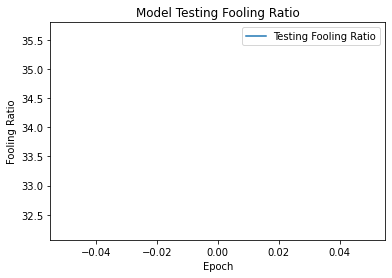

Saved plots.


In [ ]:
if mode == 'train':
    for epoch in range(1, nEpochs + 1):
        train(epoch)
        print('Testing....')
        test()
        checkpoint_dict(epoch)
    print_history()
elif mode == 'test':
    print('Testing...')
    test()
    print_history()